<a href="https://colab.research.google.com/github/daarisameen/Ml-DL-projects/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# End to End ML IITM: https://colab.research.google.com/drive/1leWpYtJrBhLf426Q2Emj1o3nNylPaJ0O?usp=sharing
# heart - https://media.licdn.com/dms/document/media/D4D1FAQFRlrkzgq8vMg/feedshare-document-pdf-analyzed/0/1696704666094?e=1698883200&v=beta&t=u-Ut36lewfXkDpX04b6MTvxFsTzVb4qkLu5AxKN4GcM
# taxi - https://media.licdn.com/dms/document/media/C4D1FAQEzUwZsEB0JLA/feedshare-document-pdf-analyzed/0/1679913090300?e=1698883200&v=beta&t=cuW5AsFBS9cZ-Va3hKcNItzeuI9Xq1xx5tx8ROQKkWY

# https://medium.com/@sthanikamsanthosh1994/context-aware-sentence-matching-using-ml-techniques-f93a28c4d1a1
# https://datascience.stackexchange.com/questions/75299/how-to-figure-out-if-two-sentences-have-the-same-meaning-with-ai
# https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb
# https://colab.research.google.com/github/mepky/movie-recommendation-system/blob/master/Movie_recommendation_engine.ipynb#scrollTo=H1Ta9vMPcsGW

# https://www.imdb.com/search/title/?num_votes=0,&countries=kr&primary_language=ko&view=advanced&sort=user_rating,desc&title_type=tv_series&sort=num_votes,desc&sort=moviemeter,asc
# https://www.imdb.com/search/title/?num_votes=0,&countries=jp&primary_language=ja&view=advanced&sort=user_rating,desc&title_type=tv_series&sort=num_votes,desc&genres=animation&sort=moviemeter,asc
# https://www.imdb.com/search/title/?num_votes=0,&view=advanced&sort=user_rating,desc&title_type=game&sort=num_votes,desc&sort=moviemeter,asc

# https://www.imdb.com/search/title/?title_type=tv_series&num_votes=0,&countries=kr&primary_language=ko&start=1&ref_=adv_nxt
# https://www.imdb.com/search/title/?title_type=tv_series&num_votes=0,&genres=animation&countries=jp&primary_language=ja&start=1&ref_=adv_nxt
# https://www.imdb.com/search/title/?title_type=video_game&num_votes=0,&start=1&ref_=adv_nxt

In [56]:
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import requests
from bs4 import BeautifulSoup
import csv

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Perceptron, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, jaccard_score

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

import pickle

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


## CREATE THE DATA SET

In [57]:
# Define the URL to scrape
urlf = "https://www.imdb.com/search/title/?title_type=tv_series&num_votes=0,&countries=kr&primary_language=ko&start="
page_no = 1
urle = "&ref_=adv_nxt"

csv_file = open("anime_data.csv", mode="w", newline='', encoding='utf-8')

# Create a CSV file to store the data
csv_file = open("anime_data.csv", mode="w", newline='', encoding="utf-8")
csv_writer = csv.writer(csv_file)

# Write the header row to the CSV file
csv_writer.writerow(["Rank", "Anime Name", "Release Year", "Genre", "Rating", "Votes", "Description", "Cast"])
rank=0
for i in range(1, 2900, 50):
    url = urlf + str(i) + urle

    # Send an HTTP GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content of the page using BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the elements containing anime data
        anime_items = soup.find_all('div', class_='lister-item-content')

        # Extract and write the data to the CSV file
        for idx, item in enumerate(anime_items):

            # Extract anime name
            anime_name = item.find('h3', class_='lister-item-header').a.text.strip()

            # Extract release year
            year_element = item.find('span', class_='lister-item-year')
            release_year = year_element.text.strip() if year_element else "N/A"

            # Extract genre as a list and remove elements with the value "Animation"
            genre_element = item.find('span', class_='genre')
            genre_list = genre_element.text.split(",") if genre_element else ["not decided"]
            genre_list = [genre.strip() for genre in genre_list]
            genre_list = [genre for genre in genre_list if genre != "Animation"]

            if not genre_list:
              genre_list = ["not decided"]

            # Extract rating
            rating_element = item.find('div', class_='inline-block ratings-imdb-rating')
            rating = rating_element.strong.text if rating_element else "N/A"

            # Extract number of votes
            votes_element = item.find('span', attrs={'name': 'nv'})
            votes = votes_element['data-value'] if votes_element else "N/A"

            # Extract description from the second 'text-muted' class
            description_element = item.find_all('p', class_='text-muted')[1]
            description = description_element.text.strip() if description_element else "N/A"

            # Extract cast names from elements with an empty class attribute
            cast_element = item.find('p', class_='')
            cast = cast_element.text.strip() if cast_element else "N/A"
            cast = [name.strip().replace("Stars:", "").strip() for name in cast.split(',')]

            # Calculate the rank as the index plus 1
            rank = rank + 1

            # Write the data to the CSV file
            csv_writer.writerow([rank, anime_name, release_year, ', '.join(genre_list), rating, votes, description, cast])


    else:
        print("Failed to retrieve the webpage. Status code:", response.status_code)

# Close the CSV file
csv_file.close()


1. Production name/Studio
2. Number of episodes and (released year)
3. Genre
4. (Plot)
5. Rating
6. Other famous anime produced by this studio
7. Please subscribe to this channel, my goal is to make my channel as No.1 anime channel in Youtube.

1. 10 Anime - If you loved "" (MUSIC).
2. center the name, put backgorund image, sub-pannels appear in anti clockwise direction.
3. Join my crew by subscribing - Monkey D Luffy.

I have a columns called
User_ratings, Movie_name, movie_description, genre, popularity_rank
write a ML code to train the model based on its description, user_rating, genre, and popularity_rank


just get the movie name from user and
and it is given that movie name will definitely present in the data set
Output should contain list of recommended movie_names

## LOAD THE DATA SET

In [69]:
data = pd.read_csv("anime_data.csv")
data[1:100]

,Rank,Anime Name,Release Year,Genre,Rating,Votes,Description,Cast
1,2,The Worst of Evil,(2023– ),"Action, Crime, Drama",8.5,1897,"In the 1990s, a police officer goes undercover...","['Ji Chang-wook', 'Wi Ha-joon', 'Im She-mi', '..."
2,3,Squid Game,(2021– ),"Action, Drama, Mystery",8.0,505795,Hundreds of cash-strapped players accept a str...,"['Lee Jung-jae', 'Park Hae-soo', 'Yasushi Iwak..."
3,4,Moving,(2023– ),"Action, Adventure, Fantasy",8.5,6661,The quiet lives of three high school students ...,"['Seung-ryong Ryu', 'Han Hyo-joo', 'Zo In-sung..."
4,5,Strong Girl Nam-soon,(2023),"Action, Comedy, Crime",7.4,423,"Gifted with superhuman strength, a young woman...","['Lee Yoo-mi', 'Kim Hae-sook', 'Seong-wu Ong',..."
5,6,The Devil's Plan,(2023– ),"Game-Show, Reality-TV",8.2,1712,"In this competition of intelligence, contestan...","['Ha Seok-jin', 'Andrew Ge', 'Roy Vongtama', '..."
...,...,...,...,...,...,...,...,...
95,96,Uncontrollably Fond,(2016),"Comedy, Drama, Romance",7.8,3676,The memory of their painful breakup still fres...,"['Kim Woo-bin', 'Bae Suzy', 'Lim Ju-hwan', 'Li..."
96,97,Because This Is My First Life,(2017),"Comedy, Drama, Romance",8.1,6679,Ji Ho is a single woman. She's a writing assis...,"['Jung So-min', 'Lee Min-ki', 'Esom', 'Byeong-..."
97,98,The Good Bad Mother,(2023– ),"Comedy, Crime, Drama",8.4,3542,A tragic accident leaves an ambitious prosecut...,"['Ra Mi-ran', 'Lee Do-hyun', 'Eun-Jin Ahn', 'M..."
98,99,Glass Mask,(2012–2013),"Drama, Romance",8.2,49,A young woman's father is a killer and she mus...,"['Park Jin-woo', 'Woo Seo', 'Ji-Hoon Lee', 'Pa..."


In [70]:
# selected_genres = ['not decided']

# # Filter rows with the selected genres
# filtered_df = data[data['Genre'].isin(selected_genres)]
# filtered_df

In [71]:
data.shape

(1668, 8)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          1668 non-null   int64  
 1   Anime Name    1668 non-null   object 
 2   Release Year  1668 non-null   object 
 3   Genre         1668 non-null   object 
 4   Rating        1668 non-null   float64
 5   Votes         1668 non-null   int64  
 6   Description   1668 non-null   object 
 7   Cast          1668 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 104.4+ KB


In [73]:
(data.isnull().sum())

Rank            0
Anime Name      0
Release Year    0
Genre           0
Rating          0
Votes           0
Description     0
Cast            0
dtype: int64

In [74]:
data['power'] = data['Rating']*data['Votes']
data['rank_rat'] = data['Rating']/data['Rank']

In [75]:
data.head()

,Rank,Anime Name,Release Year,Genre,Rating,Votes,Description,Cast,power,rank_rat
0,1,Doona!,(2023– ),"Comedy, Drama, Romance",7.2,1728,Follows the romance between a freshman college...,"['Bae Suzy', 'Yang Se-Jong', 'Harrison Xu', 'Y...",12441.6,7.200000
1,2,The Worst of Evil,(2023– ),"Action, Crime, Drama",8.5,1897,"In the 1990s, a police officer goes undercover...","['Ji Chang-wook', 'Wi Ha-joon', 'Im She-mi', '...",16124.5,4.250000
2,3,Squid Game,(2021– ),"Action, Drama, Mystery",8.0,505795,Hundreds of cash-strapped players accept a str...,"['Lee Jung-jae', 'Park Hae-soo', 'Yasushi Iwak...",4046360.0,2.666667
3,4,Moving,(2023– ),"Action, Adventure, Fantasy",8.5,6661,The quiet lives of three high school students ...,"['Seung-ryong Ryu', 'Han Hyo-joo', 'Zo In-sung...",56618.5,2.125000
4,5,Strong Girl Nam-soon,(2023),"Action, Comedy, Crime",7.4,423,"Gifted with superhuman strength, a young woman...","['Lee Yoo-mi', 'Kim Hae-sook', 'Seong-wu Ong',...",3130.2,1.480000


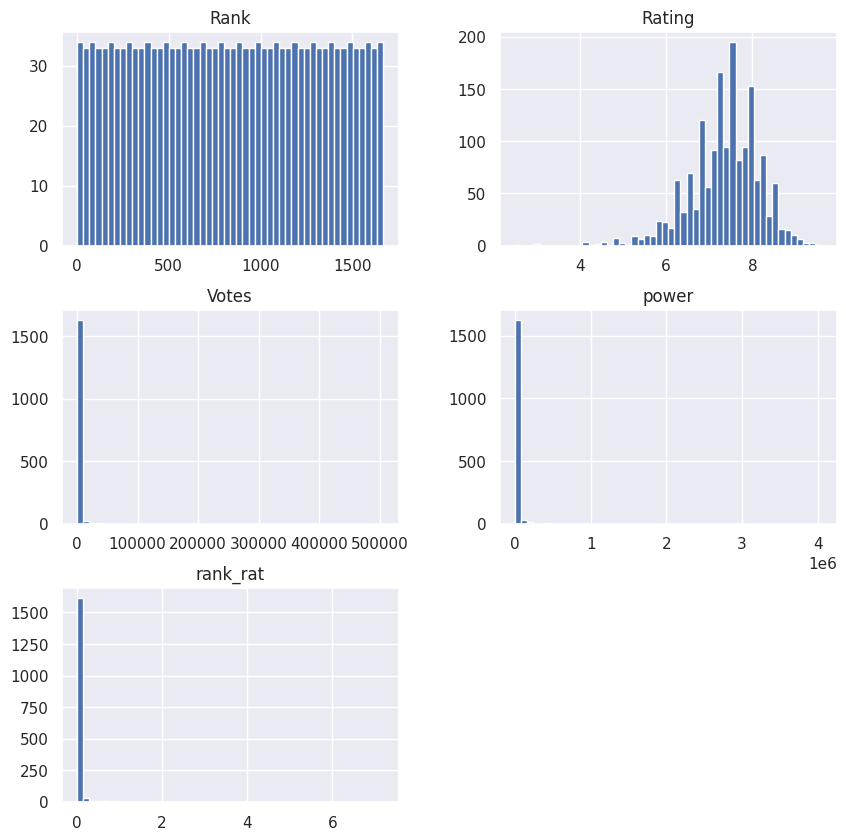

In [76]:
sns.set()
data.hist(bins=50,figsize=(10,10))
plt.show()

In [77]:
corr_matrix = data.copy().corr()
corr_matrix['Votes']

<ipython-input-77-3a72b1fd43b6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.copy().corr()


Rank       -0.165126
Rating      0.044789
Votes       1.000000
power       0.994366
rank_rat    0.327271
Name: Votes, dtype: float64

<Axes: >

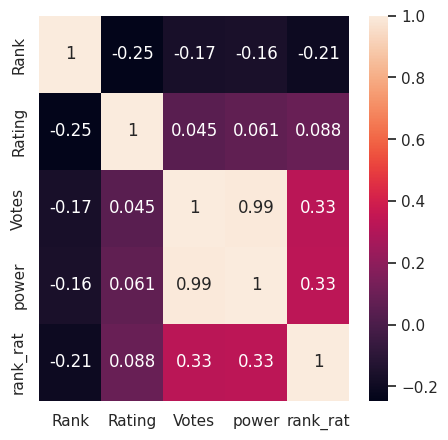

In [78]:
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True)

In [79]:
temp = data.copy()
temp = temp.drop(['Rank'],axis=1)

temp.head()

,Anime Name,Release Year,Genre,Rating,Votes,Description,Cast,power,rank_rat
0,Doona!,(2023– ),"Comedy, Drama, Romance",7.2,1728,Follows the romance between a freshman college...,"['Bae Suzy', 'Yang Se-Jong', 'Harrison Xu', 'Y...",12441.6,7.200000
1,The Worst of Evil,(2023– ),"Action, Crime, Drama",8.5,1897,"In the 1990s, a police officer goes undercover...","['Ji Chang-wook', 'Wi Ha-joon', 'Im She-mi', '...",16124.5,4.250000
2,Squid Game,(2021– ),"Action, Drama, Mystery",8.0,505795,Hundreds of cash-strapped players accept a str...,"['Lee Jung-jae', 'Park Hae-soo', 'Yasushi Iwak...",4046360.0,2.666667
3,Moving,(2023– ),"Action, Adventure, Fantasy",8.5,6661,The quiet lives of three high school students ...,"['Seung-ryong Ryu', 'Han Hyo-joo', 'Zo In-sung...",56618.5,2.125000
4,Strong Girl Nam-soon,(2023),"Action, Comedy, Crime",7.4,423,"Gifted with superhuman strength, a young woman...","['Lee Yoo-mi', 'Kim Hae-sook', 'Seong-wu Ong',...",3130.2,1.480000


In [80]:
temp.describe()

,Rating,Votes,power,rank_rat
count,1668.000000,1668.000000,1.668000e+03,1668.000000
mean,7.346523,1521.953237,1.167063e+04,0.037047
std,0.824792,13260.314585,1.039475e+05,0.236337
min,2.500000,5.000000,2.100000e+01,0.001926
25%,6.900000,31.000000,2.286250e+02,0.005803
50%,7.400000,116.000000,8.404500e+02,0.008822
75%,7.900000,626.500000,4.692000e+03,0.017876
max,9.600000,505795.000000,4.046360e+06,7.200000


In [31]:
print(data['Votes'].value_counts())
print(" ")
print(data['Genre'].value_counts())
print(" ")
print(data['Rating'].value_counts())
print(" ")

8       39
9       34
10      30
6       26
11      22
        ..
2870     1
2632     1
1152     1
1878     1
83       1
Name: Votes, Length: 776, dtype: int64
 
Drama, Romance             244
Drama                      181
Comedy, Drama, Romance     137
Comedy, Romance            114
Reality-TV                  87
                          ... 
Action, Comedy, Mystery      1
Crime, Fantasy, Romance      1
Crime, Sci-Fi, Thriller      1
Action, Fantasy, Sci-Fi      1
Comedy, Crime, Horror        1
Name: Genre, Length: 200, dtype: int64
 
7.6    103
7.4     94
7.8     94
7.3     94
7.5     93
7.1     92
8.0     81
7.7     81
7.2     72
7.9     72
6.9     67
8.1     63
7.0     56
6.8     53
8.2     52
6.3     38
6.6     36
8.3     35
6.7     35
6.5     34
6.4     32
8.6     31
8.5     30
8.4     28
6.2     25
6.0     23
5.8     18
6.1     17
8.7     15
8.8     14
5.7      9
9.0      8
5.9      6
4.8      6
5.4      6
9.1      6
5.5      5
5.3      5
5.6      5
5.2      4
5.0      3
9.4  

In [32]:
temp.shape

(1668, 7)

In [33]:
nltk.download('stopwords')
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters
    text = ''.join([char for char in text if char not in string.punctuation])

    # Remove common English stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    return text

temp['Description'] = temp['Description'].apply(preprocess_text)
temp['Description']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       follows romance freshman college student estab...
1       1990s police officer goes undercover infiltrat...
2       hundreds cashstrapped players accept strange i...
3       quiet lives three high school students genetic...
4       gifted superhuman strength young woman returns...
                              ...                        
1663    seven aspiring music industry trainees compete...
1664    look life snsd member taeyeon promotions first...
1665                                             add plot
1666    jieun heejung live father jongman truck driver...
1667                                             add plot
Name: Description, Length: 1668, dtype: object

In [ ]:
# temp = pd.get_dummies(temp, columns= ['Genre'])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(temp.head(11))

In [19]:
def cossine(input_anime, n=50):
    # Load the anime data from a CSV file
    df = temp

    # Check if the input anime is in the dataset
    if input_anime not in df['Anime Name'].values:
        return "Anime not found in the dataset"

    # Initialize the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Fit and transform the descriptions to TF-IDF vectors
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Description'])

    # Get the index of the input anime
    input_index = df[df['Anime Name'] == input_anime].index[0]

    # Calculate cosine similarities between input anime and all other anime
    cosine_similarities = linear_kernel(tfidf_matrix[input_index], tfidf_matrix).flatten()

    # Get the indices of the top-n most similar anime
    similar_indices = cosine_similarities.argsort()[:-n-1:-1]

    return similar_indices[1:]

# Example usage

input_anime_name = "Squid Game"  # Replace with the anime name you want recommendations for
indices= cossine(input_anime_name, n=50)


In [20]:
data.iloc[indices].sort_values(by=['Rank', 'Rating'], ascending=[True, False])[:10]

,Rank,Anime Name,Release Year,Genre,Rating,Votes,Description,Cast
5,6,The Devil's Plan,(2023– ),"Game-Show, Reality-TV",8.2,1712,"In this competition of intelligence, contestan...","['Ha Seok-jin', 'Andrew Ge', 'Roy Vongtama', '..."
13,14,Kingdom,(2019– ),"Action, Drama, Horror",8.3,51734,While strange rumors about their ill King grip...,"['Ju Ji-hoon', 'Bae Doona', 'Kim Sungkyu', 'Ki..."
17,18,It's Okay to Not Be Okay,(2020),"Comedy, Drama, Romance",8.6,30809,An extraordinary road to emotional healing ope...,"['Kim Soo-hyun', 'Seo Ye-Ji', 'Oh Jung-se', 'P..."
35,36,Start-Up,(2020– ),"Comedy, Drama, Romance",8.0,13348,Young entrepreneurs aspiring to launch virtual...,"['Bae Suzy', 'Nam Joo-hyuk', 'Kim Seon-Ho', 'K..."
107,108,Physical: 100,(2023– ),"Game-Show, Reality-TV",7.7,8270,One hundred contestants in top physical shape ...,"['John Choi', 'Miracle Nelson', 'Sung-Bin Yun'..."
117,118,18 Again,(2020),"Comedy, Drama, Fantasy",8.2,2741,A 37-year-old man on the verge of being divorc...,"['Ha-neul Kim', 'Yoon Sang-Hyun', 'Lee Do-hyun..."
147,148,Siren: Survive the Island,(2023– ),"Game-Show, Reality-TV",8.1,2213,"24 female police officers, firefighters, bodyg...","['Kim Bom-eun', 'Kang Eun-mi', 'Kim Eun-byul',..."
174,175,Tempted,(2018),"Drama, Mystery, Romance",7.1,2172,Love is just a game for Chaebol heir who agree...,"['Woo Do-Hwan', 'Soo-Young Park', 'Moon Ga-you..."
211,212,Big Bet,(2022– ),"Action, Crime, Drama",7.1,619,A crime-action drama about a casino king who i...,"['Choi Min-sik', 'Sukku Son', 'Lee Dong-hwi', ..."
223,224,My Perfect Stranger,(2023– ),"Drama, Mystery, Romance",8.1,605,A drama about a strange and beautiful time tra...,"['Kim Dong-wook', 'Jin Ki-joo', 'Seo Ji-Hye', ..."


Instagram

1000 to 10,000 followers -  $50/post

10,000 to 50,000 followers - $300/post

50,000 to 500,000 followers - $1500/post

500,000 to 1 million followers - $7000/post

In [81]:
def jaccard_similarity(sentence1, sentence2):
    # Tokenize the sentences (you may want to preprocess and clean the text first)
    tokens1 = set(sentence1.split())
    tokens2 = set(sentence2.split())

    # Calculate Jaccard Similarity
    intersection = len(tokens1.intersection(tokens2))
    union = len(tokens1) + len(tokens2) - intersection
    similarity = (intersection / union) * 100

    return similarity

# Example usage
sentence1 = "The quick brown fox"
sentence2 = "The brown fox jumps"
similarity_percentage = jaccard_similarity(sentence1, sentence2)
print("Jaccard Similarity Percentage:", similarity_percentage)

Jaccard Similarity Percentage: 60.0


## BERT

In [ ]:
# https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/semantic_similarity_with_bert.ipynb
# https://colab.research.google.com/github/mihaiaperghis/python-seo/blob/main/Vertify_String_Similarity_with_BERT.ipynb

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers

## Configuration

In [ ]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = ["contradiction", "entailment", "neutral"]

## Load the Data

In [ ]:
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

In [ ]:
# There are more than 550k samples in total; we will use 100k for this example.
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=100000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")

Dataset Overview:

- sentence1: The premise caption that was supplied to the author of the pair.
- sentence2: The hypothesis caption that was written by the author of the pair.
- similarity: This is the label chosen by the majority of annotators.
Where no majority exists, the label "-" is used (we will skip such samples here).

Here are the "similarity" label values in our dataset:

- Contradiction: The sentences share no similarity.
- Entailment: The sentences have similar meaning.
- Neutral: The sentences are neutral.

Let's look at one sample from the dataset:

In [ ]:
print(f"Sentence1: {train_df.loc[1, 'sentence1']}")
print(f"Sentence2: {train_df.loc[1, 'sentence2']}")
print(f"Similarity: {train_df.loc[1, 'similarity']}")

## Preprocessing

In [ ]:
# We have some NaN entries in our train data, we will simply drop them.
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

Distribution of our training targets.

In [ ]:
print("Train Target Distribution")
print(train_df.similarity.value_counts())

Distribution of our validation targets.

In [ ]:
print("Validation Target Distribution")
print(valid_df.similarity.value_counts())

The value "-" appears as part of our training and validation targets.
We will skip these samples.

In [ ]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

One-hot encode training, validation, and test labels.

In [ ]:
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

## Keras Custom Data Generator

In [ ]:

class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


## Build the model.

In [ ]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

Create train and validation data generators

In [ ]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

## Train the Model

Training is done only for the top layers to perform "feature extraction",
which will allow the model to use the representations of the pretrained model.

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

## Fine-tuning

This step must only be performed after the feature extraction model has
been trained to convergence on the new data.

This is an optional last step where `bert_model` is unfreezed and retrained
with a very low learning rate. This can deliver meaningful improvement by
incrementally adapting the pretrained features to the new data.

In [ ]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

# Train the entire model end-to-end.

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

## Evaluate model on the test set

In [ ]:
test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)

## Inference on custom sentences

In [ ]:

def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data[0])[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}%"
    pred = labels[idx]
    return pred, proba


Check results on some example sentence pairs.

In [ ]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check_similarity(sentence1, sentence2)

Check results on some example sentence pairs.

In [ ]:
sentence1 = "A smiling costumed woman is holding an umbrella"
sentence2 = "A happy woman in a fairy costume holds an umbrella"
check_similarity(sentence1, sentence2)

Check results on some example sentence pairs

In [ ]:
sentence1 = "A soccer game with multiple males playing"
sentence2 = "Some men are playing a sport"
check_similarity(sentence1, sentence2)

Example available on HuggingFace

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-semantic%20similarity%20with%20bert-black.svg)](https://huggingface.co/keras-io/bert-semantic-similarity) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-semantic%20similarity%20with%20bert-black.svg)](https://huggingface.co/spaces/keras-io/bert-semantic-similarity) |